# Genome vs Proteome

In [1]:
import pandas as pd
import numpy as np

from get_gene_info import get_genome_info, get_genes_from_ranges
from get_proteome_info import match_proteomic_data, calculate_proteomic_load
from plot_proteome import plot_perc_load, plot_distribution, plot_strain_distribution, display_side_by_side

In [2]:
# Colors for the plots

colors = {'Δ16':"#FFB700", 'MS56':"#648FFF", 'MDS69':"#82B541",
                      'DGF298':"#CC002D", 'MGF02':"#9B5EF0"}
colors2  = ["#FDA96D", "#FE6100"]


## Index
+ ### <a href="#Map_gene" style="color:#3C71FB">Map deleted genes</a>
+ ### <a href="#Map_prot" style="color:#3C71FB">Proteome mapping</a>
+ ### <a href="#Prot_load" style="color:#3C71FB">Proteomic load </a>
    + ### <a href="#Plot_load" style="color:#648FFF">Plot</a>
+ ### <a href="#Prot_dist" style="color:#3C71FB">Proteome distribution</a>
    + ### <a href="#Plot_average" style="color:#648FFF">Average</a>
    + ### <a href="#Plot_glc" style="color:#648FFF">Glucose</a>
+ ### <a href="#Prot_dist_s" style="color:#3C71FB">Proteome distribution (Deleted Genes from Strains)</a>


<p id="Map_gene"></p>

# Map deleted genes

Getting the genes that should be affected by the deleted ranges (Only for Delta 16 from MG1655 and all the W3110 strains as the others already report which genes are deleted)


#### MG1655

In [3]:
# Get the ranges from the Δ16 strain and map those genes from the NC_000913.3 NCBI entry 

delta16 = pd.read_csv('../files/deleted_ranges/delta_16.csv',encoding='latin1')
genomeMG1655_path = '../files/genomes/MG1655.gb'

genomeMG1655 = get_genome_info(genomeMG1655_path) # Read and extract info from the NCBI file 
delta_16_genes = get_genes_from_ranges(delta16, genomeMG1655) # Map the ranges to the genes
delta_16_genes = delta_16_genes.drop_duplicates()

delta_16_genes.to_csv('../files/deleted_genes/mapped_del_genes_Δ16.csv',header=True)

1170


In [4]:
# The MDS strains and the MS56 strain already had the genes reported

# MS56
genes_MS56 = list(pd.read_csv('../files/deleted_ranges/MS56.csv')['Locus_Tag'])

# MDS strains
MDS_line = pd.read_csv('../files/deleted_ranges/MDS42_69.csv')
MD12v2 = pd.read_csv('../files/deleted_ranges/MDS12_V2.csv')
MDS_line = MDS_line.set_index('bnumber')
genes_12_v2 = list(set(MD12v2['MDS12']))
genes_42 = list(set(MDS_line['MDS42_deleted'][MDS_line['MDS42_deleted']!=0].index))
genes_69 = list(set(MDS_line['MDS69_deleted'][MDS_line['MDS69_deleted']!=0].index))

In [5]:
strains_wbnumber = {'MS56':genes_MS56,'MDS12':genes_12_v2, 'MDS42':genes_42, 'MDS69':genes_69}

In [6]:
# Save this information for each strain in a csv the file 
genes_finalesMG1655 = {}

for strain in strains_wbnumber.keys():
    genes_finalesMG1655[strain] = genomeMG1655.loc[genomeMG1655.Bnumber.isin(strains_wbnumber[strain]),['Bnumber', 'Gen', 'Length']]
    genes_finalesMG1655[strain] = genes_finalesMG1655[strain].drop_duplicates()
    genes_finalesMG1655[strain].to_csv('../files/deleted_genes/mapped_del_genes_'+strain+'.csv',header=True)

#### W3110

In [7]:
# Get the ranges from the W3110 related strains and map those genes from the AP009048.1 NCBI entry 


names_W3110 = ['DGF298', 'DGF327', 'MGF02', 'MGF01' ]

rangos = pd.read_csv('../files/deleted_ranges/MGF_line.csv',encoding='latin1')
genomeW3110_path = '../files/genomes/W3110.gb'
genomeW3110 = get_genome_info(genomeW3110_path) # Read and extract info from the NCBI file 

strains = []

for name_W3110 in names_W3110:
    strains.append(rangos.loc[:,[name_W3110+'_L', name_W3110+'_R']].dropna()) # Give format to the ranges
    
genes_finalesW3110 = {}

for strain in strains:
    nombre = strain.columns[0].split('_')[0]
    genes_finalesW3110[nombre] = get_genes_from_ranges(strain, genomeW3110) # Map the ranges to the genes
    genes_finalesW3110[nombre] = genes_finalesW3110[nombre].drop_duplicates()
    
    # Save the information in a csv file 
    genes_finalesW3110[nombre].to_csv('../files/deleted_genes/mapped_del_genes_'+nombre+'.csv',header=True)    

1727
1392
1176
1035


In [8]:
# Choose some examples for visualization 

range_ej_1 = delta16.head()
range_ej_2 = strains[0].head()
gene_ej_1 = genes_finalesMG1655['MS56'].head().set_index('Bnumber')
gene_ej_2 = genes_finalesW3110['DGF298'].head().set_index('Bnumber')

In the end, ranges from the strains from MG1655 and W3110 were mapped to its genes.

<div class="alert alert-block alert-info">
<b>Mapping genes:</b> In the end, ranges from the strains from MG1655 and W3110 were mapped to its genes.</div>
​

In [9]:
display_side_by_side(range_ej_1, gene_ej_1, range_ej_2, gene_ej_2, titles=['Ranges Δ16 ->','Genes Δ16','Ranges DGF->','Genes DGF']) 

,D16_L,D16_R
0,2947930,2962780
1,289030,366193
2,3542486,3572350
3,4619264,4637974
4,3533214,3552459
,Gen,Length
Bnumber,,
b0016,insL-1,1114
b0018,mokC,211
b0019,nhaA,1168


<p id="Map_prot"></p>

# Proteome mapping

See how much the deleted genes represent in proteome fraction for each of the conditions of the Schmidt et al, 2016
data

In [10]:
# Proteomic data from Schmidt et al, 2016

proteomic_data = pd.read_excel("../files/proteome_Schmidt/Proteomic_data_fg.xlsx") 
proteome_size = pd.read_excel("../files/proteome_Schmidt/Proteome_size.xlsx")

In [11]:
# Example of the information (protein in fg)

proteomic_data.iloc[0:5,0:5]

,Bnumber,Gene,Glucosa,LB,Glicerol + AA
0,b2836,aas,0.000845,0.001648,0.001316
1,b0185,accA,0.223594,0.465969,0.396601
2,b3255,accB,0.071193,0.168232,0.122404
3,b3256,accC,0.148113,0.437881,0.259203
4,b2316,accD,0.091758,0.190092,0.155012


In [12]:
# Total proteome in fg for each condition
proteome_size.iloc[:,0:5]

,Unnamed: 0,Glucosa,LB,Glicerol + AA,Acetato
0,Proteoma Total,243.195528,366.968242,326.553153,196.363377


#### MG1655

In [13]:
names_MG1655 = ['Δ16', 'MS56', 'MDS69','MDS42','MDS12']
cepas_MG1655 = {}

for name_MG1655 in names_MG1655:
    strain_df = pd.read_csv("../files/deleted_genes/mapped_del_genes_"+name_MG1655+".csv")
    strain_df = strain_df.drop('Unnamed: 0', axis=1)
    cepas_MG1655[name_MG1655] = strain_df

#### W3110

In [14]:
cepas_W3110 = {}

for name_W3110 in names_W3110:
    strain_df = pd.read_csv("../files/deleted_genes/mapped_del_genes_"+name_W3110+".csv")
    strain_df = strain_df.drop('Unnamed: 0', axis=1)
    cepas_W3110[name_W3110]=strain_df

In [15]:
    display_side_by_side(cepas_MG1655['MS56'].head(), cepas_W3110['DGF298'].head(), titles=['MG1655 (MS56)','W3110 (DGF298)']) 

,Bnumber,Gen,Length
0,b0016,insL-1,1114
1,b0018,mokC,211
2,b0019,nhaA,1168
3,b0020,nhaR,907
4,b0022,insA-1,277
,Bnumber,Gen,Length
0,b0714,nei,793
1,b0715,abrB,1048
2,b0716,ybgO,1063
3,b0717,ybgP,730


In [16]:
matched_genes_cepas_MG1655 = match_proteomic_data(names_MG1655, cepas_MG1655, proteomic_data)
matched_genes_cepas_W3110 = match_proteomic_data(names_W3110, cepas_W3110, proteomic_data)

<div class="alert alert-block alert-info">
<b>Proteome mapping:</b> We mapped the deleted genes of every strain with the proteomic data</div>
​

In [17]:
display_side_by_side(matched_genes_cepas_MG1655['MS56'].head().iloc[:,0:6], matched_genes_cepas_W3110['DGF298'].head().iloc[:,0:6], titles=['MG1655 (MS56)','W3110 (DGF298)']) 

,Bnumber,Gene,Gen NCBI,Length,Glucosa,LB
26,b3714,adeP,adeP,1339,0.007098,3.361445e-03
28,b1478,adhP,adhP,1012,0.001540,2.830379e-03
33,b1002,agp,agp,1243,0.037989,1.035732e-01
44,b0516,allC,allC,1237,0.000009,1.736672e-07
45,b0506,allR,allR,817,0.009976,8.665591e-03
,Bnumber,Gene,Gen NCBI,Length,Glucosa,LB
20,b4069,acs,acs,1960,0.118984,0.280561
21,b4067,actP,actP,1651,0.003972,0.011103
25,b3665,ade,ade,1768,0.000522,0.005758
26,b3714,adeP,yieG,1339,0.007098,0.003361


<p id="Prot_load"></p>

# Proteomic load 

Now that we have the data mapped, we calculate how much of the proteome would be released by eliminating the genes reported by each strain

In [18]:
prot_load_MG1655, prot_perc_MG1655 = calculate_proteomic_load(names_MG1655, matched_genes_cepas_MG1655, proteome_size  )
prot_load_W3110, prot_perc_W3110 = calculate_proteomic_load(names_W3110, matched_genes_cepas_W3110, proteome_size  )

In [19]:
# We join the information for both strains and format it for visualization
prot_load = prot_load_MG1655+prot_load_W3110
prot_perc = prot_perc_MG1655+prot_perc_W3110

prot_load = (pd.concat(prot_load,axis=1))
prot_perc = (pd.concat(prot_perc,axis=0).T)

<div class="alert alert-block alert-info">
<b>Proteome load:</b> Now we know the estimated proteomic load released (in fg and percentage) by eliminating the genes reported by each strain </div>
​

In [20]:
    display_side_by_side(prot_load.iloc[0:5,0::2], prot_perc.iloc[0:5,0::2], titles=['Proteome Load','Proteome Percentage']) 

,Δ16,MDS69,MDS12,DGF327,MGF01
Glucosa,20.429299,5.976414,1.760846,13.387407,9.758176
LB,29.830063,11.564342,1.707077,21.614665,13.103638
Glicerol + AA,28.959023,13.794031,2.207994,28.235209,13.582319
Acetato,25.791522,9.116245,1.721988,16.776233,13.2063
Fumarato,24.530995,8.501137,1.724558,19.209616,14.41106
,Δ16,MDS69,MDS12,DGF327,MGF01
Glucosa,8.40036,2.457452,0.724045,5.504791,4.012482
LB,8.128786,3.15132,0.465184,5.890064,3.570783
Glicerol + AA,8.868089,4.22413,0.676152,8.646436,4.159298
Acetato,13.134589,4.642538,0.87694,8.543463,6.725439


We plot only some of the conditions to make easier the visualization

In [21]:
# To plot all the conditions 
#new_order = ["LB","Glicerol + AA","42°C glucosa","Fructosa","pH6 glucosa",
#             "Glucosa","Estrés-osmótico glucosa","Xilosa","Quimiostato µ=0.5",
#             "Manosa","Glicerol","Glucosamina","Succinato","Fumarato","Piruvato",
#             "Quimiostato µ=0.35","Acetato","Galactosa","Quimiostato µ=0.20",
#             "Quimiostato µ=0.12","Fase estacionaria 1 día","Fase estacionaria 3 días"]
#plot_perc_load(prot_load, prot_perc, conditions = new_order, save=True, identifier='K12' )

In [22]:
representative_conditions = ["LB","Fructosa", "Glucosa","Estrés-osmótico glucosa",
                             "Quimiostato µ=0.5", "Glicerol","Fumarato","Piruvato",
                             "Acetato","Galactosa", "Quimiostato µ=0.12","Fase estacionaria 1 día"]
representative_strains = ['Δ16', 'MS56', 'MDS69', 'DGF298', 'MGF02']

<p id="Plot_load"></p>

<div class="alert alert-block alert-success">
<b>Plot proteomic load</b> 
</div>



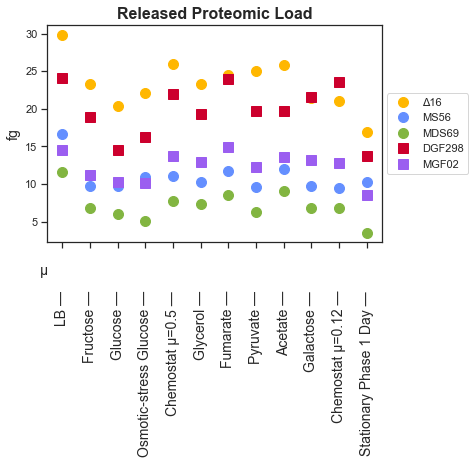

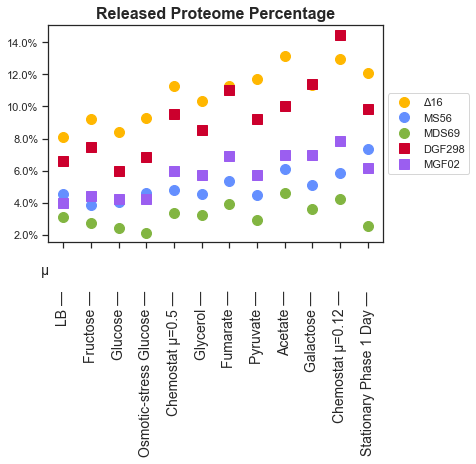

In [23]:
plot_perc_load(prot_load, prot_perc, conditions = representative_conditions,
               strains = representative_strains, identifier='K12', colors_per_strain = colors )

<p id="Prot_dist"></p>

# Proteome distribution

Now lets see how the proteome is distributed

In [24]:
# We take the average of proteomic load of each gene per condition

distribucion_prot = pd.DataFrame({'Gen':proteomic_data.Bnumber,'Promedio':proteomic_data.iloc[:,2:24].T.mean(),'STD':proteomic_data.iloc[:,2:24].T.std()})

In [25]:
distribucion_prot = distribucion_prot.sort_values(by='Promedio',ascending=False).reset_index().drop(columns=['index'])

<div class="alert alert-block alert-info">
<b>Average proteome distribution</b> </div>
​

In [26]:
distribucion_prot.head()

,Gen,Promedio,STD
0,b3339,14.050141,6.025027
1,b4015,7.379211,5.911134
2,b0957,6.355356,1.664707
3,b3340,3.947647,2.130137
4,b2414,3.670652,1.389756


<p id="Plot_average"></p>

<div class="alert alert-block alert-success">
<b>Plot average proteome distribution</b> 
</div>



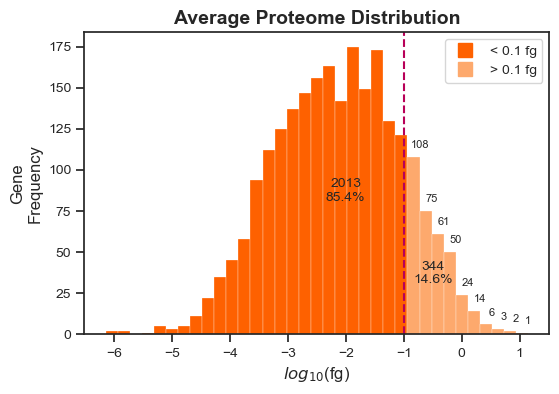

In [27]:
plot_distribution(distribucion_prot, 'Promedio', eng=True, colors_distribution = colors2 ) 

We can also see the distribution for each condition 

In [28]:
distribucion_prot_glc = pd.DataFrame({'Gen':proteomic_data.Bnumber,'Glucosa':proteomic_data['Glucosa']})

In [29]:
distribucion_prot_glc = distribucion_prot_glc.loc[distribucion_prot_glc['Glucosa']>0] 

<p id="Plot_glc"></p>

<div class="alert alert-block alert-success">
<b>Plot proteome distribution in glucose condition</b> 
</div>


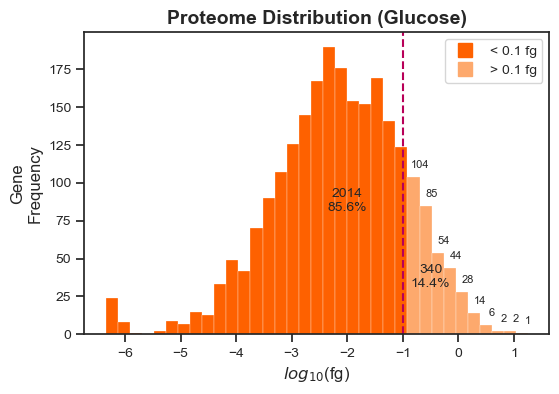

In [30]:
plot_distribution(distribucion_prot_glc , 'Glucosa', eng=True, colors_distribution = colors2) 

<p id="Prot_dist_s"></p>

# Proteome distribution (Deleted Genes from Strains)

Now we analyze the distribution of the estimated proteomic load released from the eliminated the genes reported by each strain

In [31]:
# Filtering data

genes_total = {}
for strain, info in matched_genes_cepas_W3110.items():
    genes_total[strain] = info.Bnumber
for strain, info in matched_genes_cepas_MG1655.items():
    genes_total[strain] = info.Bnumber


<div class="alert alert-block alert-success">
<b>Plot proteome distribution of deleted genes in glucose condition </b> 
</div>



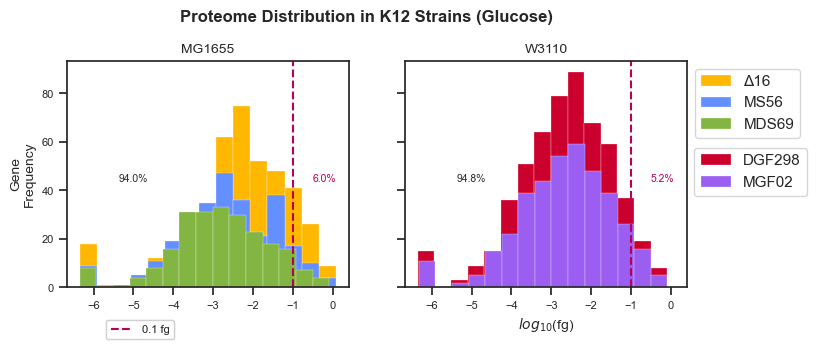

In [32]:
plot_strain_distribution(genes_total, distribucion_prot_glc, representative_strains, 'K12',
                         'Glucosa', save=True, identifier='Multi_panel_dist_cepas_2', colors_per_strain = colors )